In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import glob
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from utils.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor

SD pipeline

In [2]:
# Setup
seed=1024
generator = torch.Generator("cuda").manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(0)
random.seed(0)

# Using 512x512 resolution
model_id = "stabilityai/stable-diffusion-2-base"
# model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id)#, torch_dtype=torch.float16)
device = "cuda"
pipe = pipe.to(device)
pipe.safety_checker = None
scheduler_config = pipe.scheduler.config

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 11628.48it/s]


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


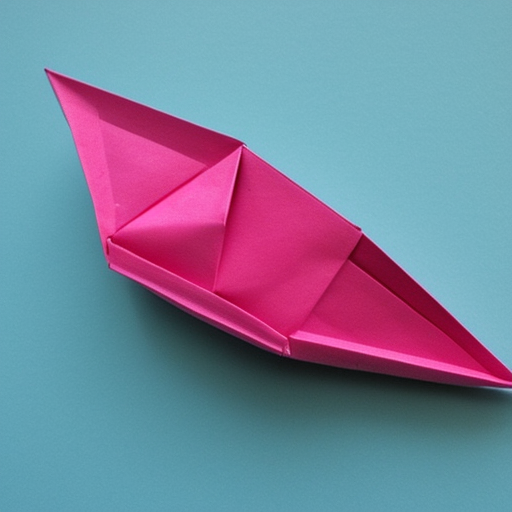

In [31]:
# Diffusion using pipeline
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler, EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, DDIMScheduler, PNDMScheduler, ScoreSdeVeScheduler, UniPCMultistepScheduler
pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_config)

num_cols = 1
num_rows = 1

seed=1024
generator = torch.Generator("cuda").manual_seed(seed)
# prompt = ["full length shot, super hero pose, biomechanical suit, inflatable shapes, wearing epic bionic cyborg implants, masterpiece, intricate, biopunk futuristic wardrobe, highly detailed, artstation, concept art, cyberpunk, octane render"]
prompt = ["origami boat"]

prompt = prompt* num_cols

all_images = []
for i in range(num_rows):
  images = pipe(prompt, num_inference_steps=20, generator=generator, guidance_scale=8).images
  all_images.extend(images)

grid = image_grid(all_images, rows=num_rows, cols=num_cols)
grid

Pipeline from scratch

In [11]:
# Settings
prompt = ["origami boat"]
height, width = 512,512
num_inference_steps=20
cfg=8
batch_size=1

# Select scheduler
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler, EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, DDIMScheduler, PNDMScheduler, ScoreSdeVeScheduler
# pipe.scheduler = ScoreSdeVeScheduler(sigma_max=15, num_train_timesteps=1000)
# mod_config = dict(scheduler_config.items())
# mod_config['num_train_timesteps'] = num_inference_steps
# eulerscheduler = EulerDiscreteScheduler.from_config(scheduler_config)
# eulerscheduler.set_timesteps(num_inference_steps)

# Custom scheduler
euler_discrete_config = {
    "num_train_timesteps" : 1000,
    "beta_start" : 0.00085,
    "beta_end" : 0.012,
    "beta_schedule" : "scaled_linear",
    "prediction_type" : "epsilon",
    "interpolation_type" : "linear",
}
pipe.scheduler = EulerDiscreteCustomScheduler(**euler_discrete_config)
pipe.scheduler.config = FrozenDict(euler_discrete_config)

In [130]:
pipe.scheduler.sigmas

tensor([14.6146, 10.7468,  8.0815,  6.2050,  4.8557,  3.8654,  3.1238,  2.5572,
         2.1157,  1.7648,  1.4806,  1.2458,  1.0481,  0.8784,  0.7297,  0.5964,
         0.4736,  0.3555,  0.2322,  0.0292,  0.0000])

In [131]:
sigmas

tensor([25.1461, 18.4360, 13.7221, 10.3657,  7.9434,  6.1711,  4.8564,  3.8669,
         3.1111,  2.5248,  2.0623,  1.6912,  1.3877,  1.1346,  0.9190,  0.7310,
         0.5625,  0.4061,  0.2514,  0.0292,  0.0000], device='cuda:0')

In [4]:
seed=1024
generator = torch.Generator("cuda").manual_seed(seed)
text_input = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
max_length = text_input.input_ids.shape[-1]
uncond_input = pipe.tokenizer([""] * batch_size, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Init latents
init_latents = torch.randn(
    (batch_size, pipe.unet.in_channels, height//8, width//8),
    generator=generator,
    device=device,
)#.type(torch.float16)

In [7]:
def step_correct(
        model_output: torch.FloatTensor,
        sample: torch.FloatTensor,
        generator: Optional[torch.Generator] = None,
        snr = 0.1
    ):
        """
        Correct the predicted sample based on the output model_output of the network. This is often run repeatedly
        after making the prediction for the previous timestep.

        Args:
            model_output (`torch.FloatTensor`): direct output from learned diffusion model.
            sample (`torch.FloatTensor`):
                current instance of sample being created by diffusion process.
            generator: random number generator.
            return_dict (`bool`): option for returning tuple rather than SchedulerOutput class

        Returns:
            [`~schedulers.scheduling_sde_ve.SdeVeOutput`] or `tuple`: [`~schedulers.scheduling_sde_ve.SdeVeOutput`] if
            `return_dict` is True, otherwise a `tuple`. When returning a tuple, the first element is the sample tensor.

        """
        # For small batch sizes, the paper "suggest replacing norm(z) with sqrt(d), where d is the dim. of z"
        # sample noise for correction
        noise = torch.randn(sample.shape, layout=sample.layout, generator=generator).to(sample.device)

        # compute step size from the model_output, the noise, and the snr
        grad_norm = torch.norm(model_output.reshape(model_output.shape[0], -1), dim=-1).mean()
        noise_norm = torch.norm(noise.reshape(noise.shape[0], -1), dim=-1).mean()
        step_size = (snr * noise_norm / grad_norm) ** 2 * 2
        step_size = step_size * torch.ones(sample.shape[0]).to(sample.device)
        # self.repeat_scalar(step_size, sample.shape[0])

        # compute corrected sample: model_output term and noise term
        step_size = step_size.flatten()
        while len(step_size.shape) < len(sample.shape):
            step_size = step_size.unsqueeze(-1)
        prev_sample_mean = sample + step_size * model_output
        prev_sample = prev_sample_mean + ((step_size * 2) ** 0.5) * noise

        return prev_sample

In [16]:
# Denoise loop
from tqdm.auto import tqdm
from torch import autocast

# Set initial latent
pipe.scheduler.set_timesteps(num_inference_steps)
latents = init_latents * pipe.scheduler.init_noise_sigma
# seed=1024
# generator = torch.Generator("cuda").manual_seed(seed)

latent_list = [latents]
for t in tqdm(pipe.scheduler.timesteps):
    # expand latents for cfg to avoid 2 forward passes
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict noise residual
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + cfg * (noise_pred_text - noise_pred_uncond)
    
    # compute previous noisy sample x_t -> x_t-1
    # latents = pipe.scheduler.step(noise_pred, t, latents, generator=generator).prev_sample

    # stochastic s_churn=10, s_tmin=0.3, s_tmax=10, s_noise=1.003
    latents = pipe.scheduler.step(noise_pred, t, latents, generator=generator).prev_sample
    latent_list.append(latents)

    # Corrections
    # latents = pipe.scheduler.step(noise_pred, t, latents, generator=generator).prev_sample
    # if t>950:
    #     for _ in range(100):
    #         latents = step_correct(noise_pred, latents)
    #         latent_list.append(latents)
    # else:
    #     latent_list.append(latents)

100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


SCRATCH

In [28]:
# Settings
prompt = ["origami boat"]
height, width = 512,512
num_inference_steps=20
cfg=8
batch_size=1

device = "cuda"
num_train_timesteps =  1000
beta_start = 0.00085
beta_end = 0.012
# linear
# betas = torch.linspace(beta_start, beta_end, num_train_timesteps, dtype=torch.float32)
#scaled linear
betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps, dtype=torch.float32) ** 2
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

# set_timesteps - set sigmas for num_inference_steps noise levels by interpolating training sigmas
timesteps = np.linspace(0, num_train_timesteps - 1, num_inference_steps, dtype=float)[::-1].copy()
sigmas = np.array(((1 - alphas_cumprod) / alphas_cumprod) ** 0.5)
sigmas = np.interp(timesteps, np.arange(0, len(sigmas)), sigmas)
sigmas = np.concatenate([sigmas, [0.0]]).astype(np.float32)

timesteps = torch.from_numpy(timesteps).to(device)
sigmas = torch.from_numpy(sigmas).to(device=device)

def step(
        model_output: torch.FloatTensor,
        timestep: Union[float, torch.FloatTensor],
        sample: torch.FloatTensor,
        s_churn: float = 0.0,
        s_tmin: float = 0.0,
        s_tmax: float = float("inf"),
        s_noise: float = 1.0,
        generator: Optional[torch.Generator] = None,
    ):
        """
        Predict the sample at the previous timestep by reversing the SDE. Core function to propagate the diffusion
        process from the learned model outputs (most often the predicted noise)."""

        step_index = (timesteps == timestep).nonzero().item()
        sigma = sigmas[step_index]

        gamma = min(s_churn / (len(sigmas) - 1), 2**0.5 - 1) if s_tmin <= sigma <= s_tmax else 0.0

        noise = randn_tensor(
            model_output.shape, dtype=model_output.dtype, device=model_output.device, generator=generator
        )

        eps = noise * s_noise
        sigma_hat = sigma * (gamma + 1)

        if gamma > 0:
            sample = sample + eps * (sigma_hat**2 - sigma**2) ** 0.5

        # 1. compute predicted original sample (x_0) from sigma-scaled predicted noise
        
        # based on reparameterisation Appendix B SD paper
        # NOTE: model_output evaluated on sigma, not sigma_hat - maybe not relevant with more timesteps
        pred_original_sample = sample - sigma_hat * model_output

        # 2. Convert to an ODE derivative
        derivative = (sample - pred_original_sample) / sigma_hat

        dt = sigmas[step_index + 1] - sigma_hat

        prev_sample = sample + derivative * dt

        # NOTE: No 2nd order correction here (would require another score evaluation)

        return prev_sample

def scale_input(sample, sigma):
    """Scales the denoising model input by `(sigma**2 + 1) ** 0.5` to match the Euler algorithm."""
    sample = sample / ((sigma**2 + 1) ** 0.5)
    return sample

def get_score(sample, sigma, t):
    # expand latents for cfg to avoid 2 forward passes
    latent_model_input = torch.cat([sample] * 2)
    latent_model_input = scale_input(latent_model_input, sigma)

    # predict noise residual
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + cfg * (noise_pred_text - noise_pred_uncond)

    # D (pred_original_sample)
    D = sample - sigma * noise_pred

    # score
    score = (D - sample) / (sigma**2)

    return score
      

def step_score(
        sample: torch.FloatTensor,
        score: torch.FloatTensor,
        sigma_index,
    ):
        """
        Predict the sample at the previous timestep by reversing the SDE. Core function to propagate the diffusion
        process from the learned model outputs (most often the predicted noise)."""
        sigma = sigmas[sigma_index]
        derivative = - sigma * score

        dt = sigmas[sigma_index + 1] - sigma

        prev_sample = sample + derivative * dt

        return prev_sample

In [29]:
# standard deviation of the initial noise distribution
init_noise_sigma = sigmas.max()
latents = init_latents * init_noise_sigma
# seed=1024
# generator = torch.Generator("cuda").manual_seed(seed)

latent_list = [latents]
for t in tqdm(timesteps):
    t = t.to(device)
    step_index = (timesteps == t).nonzero().item()
    sigma = sigmas[step_index]
    
    score = get_score(latents, sigma, t)
    latents = step_score(latents, score, step_index)

    latent_list.append(latents)

100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


In [159]:
sigmas[8]=sigmas[7]

In [8]:
# Flexible sigmas
sigmas

tensor([14.6146, 10.7468,  8.0815,  6.2050,  4.8557,  3.8654,  3.1238,  2.5572,
         2.1157,  1.7648,  1.4806,  1.2458,  1.0481,  0.8784,  0.7297,  0.5964,
         0.4736,  0.3555,  0.2322,  0.0292,  0.0000], device='cuda:0')

Visualise

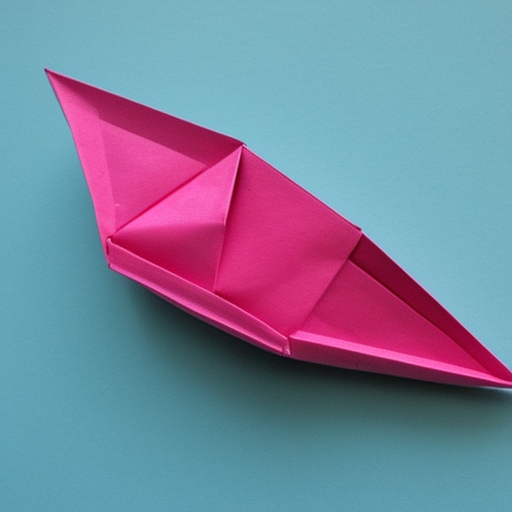

In [30]:
# Plot image results
image = output_to_img(decode_latent(latents, pipe.vae))
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

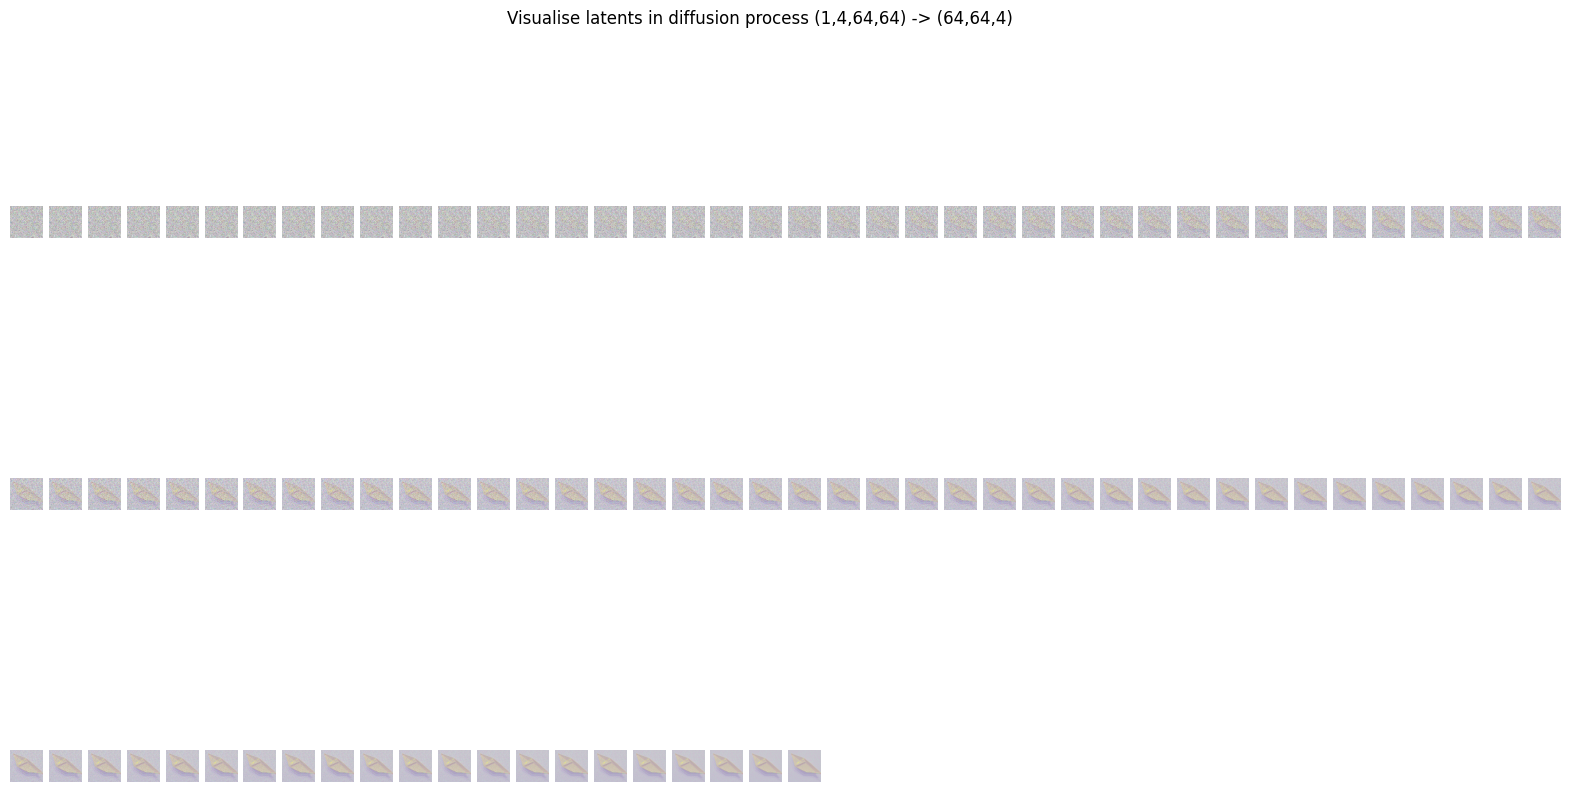

In [12]:
# Visualise latents in diffusion process
import matplotlib.pyplot as plt
lats = latent_to_img(latent_list)
plt.figure(figsize=(20,10))
plt.suptitle("Visualise latents in diffusion process (1,4,64,64) -> (64,64,4)")
for i, lat in enumerate(lats):
    plt.subplot(3,40,i+1)
    plt.axis('off')
    plt.imshow(lat)

Generate samples

In [ ]:
# List out all fruit
# Save all ["{fruit} on white plate"] into data folder
# Compute FID score or save encodings of Inception network

In [64]:
import yaml
with open("data/labels.yaml", 'r') as stream:
    labels = yaml.safe_load(stream)
with open("data/config.yaml", 'r') as stream:
    params = yaml.safe_load(stream)

In [21]:
# Generating samples for specific label specified by config
foldername = "sample"
for label in labels['fruit']:
    # prompt = f"{label} on a white plate"
    prompt = f"{label}, white background"
    filename = label.replace(" ", "_")
    dst_path = os.path.join("data",foldername, filename)
    os.makedirs(dst_path, exist_ok=True)
    print(label)
    for i in range(params['samples_per_class']):
        print(f"{filename}_{i}.png")
        img = pipe(prompt, 
                    num_inference_steps = params['num_steps'], 
                    guidance_scale = params['cfg'],
                    generator=generator).images[0]
        img.save(os.path.join(dst_path , f"{filename}_{i}.png"))

apple
apple_0.png


100%|██████████| 20/20 [00:01<00:00, 12.34it/s]


apple_1.png


100%|██████████| 20/20 [00:01<00:00, 12.75it/s]


apple_2.png


100%|██████████| 20/20 [00:01<00:00, 12.70it/s]


apple_3.png


100%|██████████| 20/20 [00:01<00:00, 12.70it/s]


strawberry
strawberry_0.png


100%|██████████| 20/20 [00:01<00:00, 12.69it/s]


strawberry_1.png


100%|██████████| 20/20 [00:01<00:00, 12.67it/s]


strawberry_2.png


100%|██████████| 20/20 [00:01<00:00, 12.65it/s]


strawberry_3.png


100%|██████████| 20/20 [00:01<00:00, 12.60it/s]


lemon
lemon_0.png


100%|██████████| 20/20 [00:01<00:00, 12.61it/s]


lemon_1.png


100%|██████████| 20/20 [00:01<00:00, 12.58it/s]


lemon_2.png


100%|██████████| 20/20 [00:01<00:00, 12.58it/s]


lemon_3.png


100%|██████████| 20/20 [00:01<00:00, 12.56it/s]


orange
orange_0.png


100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


orange_1.png


100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


orange_2.png


100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


orange_3.png


100%|██████████| 20/20 [00:01<00:00, 12.46it/s]


banana
banana_0.png


100%|██████████| 20/20 [00:01<00:00, 12.45it/s]


banana_1.png


100%|██████████| 20/20 [00:01<00:00, 12.45it/s]


banana_2.png


100%|██████████| 20/20 [00:01<00:00, 12.43it/s]


banana_3.png


100%|██████████| 20/20 [00:01<00:00, 12.42it/s]


custard apple
custard_apple_0.png


100%|██████████| 20/20 [00:01<00:00, 12.39it/s]


custard_apple_1.png


100%|██████████| 20/20 [00:01<00:00, 12.38it/s]


custard_apple_2.png


100%|██████████| 20/20 [00:01<00:00, 12.37it/s]


custard_apple_3.png


100%|██████████| 20/20 [00:01<00:00, 12.34it/s]


fig
fig_0.png


100%|██████████| 20/20 [00:01<00:00, 12.34it/s]


fig_1.png


100%|██████████| 20/20 [00:01<00:00, 12.34it/s]


fig_2.png


100%|██████████| 20/20 [00:01<00:00, 12.34it/s]


fig_3.png


100%|██████████| 20/20 [00:01<00:00, 12.35it/s]


jackfruit
jackfruit_0.png


100%|██████████| 20/20 [00:01<00:00, 12.32it/s]


jackfruit_1.png


100%|██████████| 20/20 [00:01<00:00, 12.31it/s]


jackfruit_2.png


100%|██████████| 20/20 [00:01<00:00, 12.30it/s]


jackfruit_3.png


100%|██████████| 20/20 [00:01<00:00, 12.29it/s]


pineapple
pineapple_0.png


100%|██████████| 20/20 [00:01<00:00, 12.23it/s]


pineapple_1.png


100%|██████████| 20/20 [00:01<00:00, 12.23it/s]


pineapple_2.png


100%|██████████| 20/20 [00:01<00:00, 12.23it/s]


pineapple_3.png


100%|██████████| 20/20 [00:01<00:00, 12.23it/s]


pomegranate
pomegranate_0.png


100%|██████████| 20/20 [00:01<00:00, 12.23it/s]


pomegranate_1.png


100%|██████████| 20/20 [00:01<00:00, 12.23it/s]


pomegranate_2.png


100%|██████████| 20/20 [00:01<00:00, 12.21it/s]


pomegranate_3.png


100%|██████████| 20/20 [00:01<00:00, 12.23it/s]


FID CALCULATION

In [1]:
import glob
f = []
for file in glob.glob("data/fruit_white/*/*"):
    f.append(file)

In [197]:
f = []
for file in glob.glob("data/sample/apple_white_1k/*"):
    f.append(file)

In [8]:
len(f[:1000])

1000

In [2]:
files = f[1000:2000]

In [198]:
len(f)

1000

In [5]:
fid_dir = "fid" #/pt_inception-2015-12-05-6726825d.pth"
dims = 2048
device = 'cuda'
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx], model_dir=fid_dir).to(device)
m, s = calculate_activation_statistics(f, model, 8, dims, device)

# act = get_activations(f, model, 8, dims, device, None)

save_statistics("data/apple_white_1k_sample_fid.npz",m,s)

# load precomputed m, s
# path = os.path.join(fid_dir, args.dataset + '.npz')
# m0, s0 = load_statistics(path)

# fid = calculate_frechet_distance(m0, s0, m, s)

/data/ap2619/diffusion/score_sde_pytorch/.venv_score/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/diffusion/score_sde_pytorch/.venv_score/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.


In [202]:
m, s = load_statistics("data/apple_white_1k_sample_fid.npz")
m0, s0 = load_statistics("data/fruit_white_fid.npz")
# m, s = load_statistics("data/apple_fid.npz")
# m0, s0 = load_statistics("data/fruits_fid.npz")
fid = calculate_frechet_distance(m0, s0, m, s)

In [203]:
fid

161.277074778167

In [98]:
m, s = load_statistics("data/apple_white_adjectives_fid.npz")

In [204]:
# Get largest eigenvalue
eigenValues, eigenVectors = np.linalg.eig(s)

idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenValues[0]

(14.290142360999806+0j)

In [8]:
# Plot images from dataset
import glob
n=2
images = []
for folder in glob.glob("data/fruit/*"):
    i=0
    for file in glob.glob(os.path.join(folder,"*")):
        if i<n:
            images.append(Image.open(file))
            i+=1

grid = image_grid(images, rows=n, cols=10)



In [9]:
grid.save("out.png")

In [65]:
# Generate 1k images of "apple, white background, {adjective}" with 100 adjectives in csv (10 samples each)
import pandas as pd
adjectives = pd.read_csv("data/adjectives.csv",header=None)
for adj in adjectives[0]:
    # prompt = f"{label} on a white plate"
    prompt = f"apple, white background, {adj}"
    filename = "apple_" + adj.replace(" ", "_")
    dst_path = os.path.join("data","sample", "apple_adjectives")
    os.makedirs(dst_path, exist_ok=True)
    print(adj)
    for i in range(params['samples_per_class']):
        print(f"{filename}_{i}.png")
        img = pipe(prompt, 
                    num_inference_steps = params['num_steps'], 
                    guidance_scale = params['cfg'],
                    generator=generator).images[0]
        img.save(os.path.join(dst_path , f"{filename}_{i}.png"))

photorealistic
apple_photorealistic_0.png


100%|██████████| 20/20 [00:01<00:00, 12.64it/s]


t-SNE